In [1]:
# Imports and defining matrices
import numpy as np
from numpy import pi, cos, sin

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('matplotlib_styles/line_plot.mplstyle')

# Define Pauli and Gamma matrices for convenience
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

gamma_0 = np.kron(sigma_0, sigma_0)
gamma_1 = np.kron(sigma_x, sigma_z)
gamma_2 = np.kron(-sigma_y, sigma_0)
gamma_3 = np.kron(sigma_z, sigma_0)
gamma_4 = np.kron(sigma_x, sigma_x)
gamma_5 = np.kron(sigma_x, sigma_y)

# BZ path utilities

In [2]:
def high_symmetry_bz_path_2d(tot_nk: int):
    """
    Produces a list of crystal momentum points along a path traversing high-symmetry lines of the cubic BZ

    Parameters
    ----------
    tot_nk : int
        The desired number of points on the momentum path

    Returns
    -------
    path: List
        A list of approximately tot_nk crystal momentum points on the high-symmetry path
    nodes: List
        A list of the indices of high-symmetry points on the path
    labels: List
        A list of strings labeling the high-symmetry points enumerated by 'nodes'   

    """
    nk = tot_nk // (3 + np.sqrt(2))

    gamma = (0, 0)
    x = (pi, 0)
    m = (pi, pi)

    point_list = [gamma, x, m, gamma]
    labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
    norm_list  = [1, 1, np.sqrt(2)]
    k_nodes = [int(np.floor(nk * norm)) for norm in norm_list]

    path = []
    for ii, norm in enumerate(norm_list):
        ki = point_list[ii]
        kf = point_list[ii + 1]

        [kx, ky] = [list(np.linspace(ki[jj], kf[jj], k_nodes[ii] + 1))[:-1] for jj in range(2)]

        path = path + list(zip(kx, ky))
    
    path = path + [point_list[-1]]
    
    return path, np.cumsum([0, ] + k_nodes), labels


def high_symmetry_bz_path_3d(tot_nk: int):
    """
    Produces a list of crystal momentum points along a path traversing high-symmetry lines of the cubic BZ

    Parameters
    ----------
    tot_nk : int
        The desired number of points on the momentum path

    Returns
    -------
    path: List
        A list of approximately tot_nk crystal momentum points on the high-symmetry path
    nodes: List
        A list of the indices of high-symmetry points on the path
    labels: List
        A list of strings labeling the high-symmetry points enumerated by 'nodes'   

    """
    nk = tot_nk // (5 + 2 * np.sqrt(2))

    gamma = (0, 0, 0)
    x = (pi, 0, 0)
    z = (0, 0, pi)
    m = (pi, pi, 0)
    r = (pi, 0, pi)
    a = (pi, pi, pi)

    point_list = [gamma, x, m, gamma, z, r, a, z, a, m, x, r]
    labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$', r'$Z$', r'$R$', r'$A$', r'$Z$', r'$A$', r'$M$', r'$X$', r'$R$']
    norm_list  = [1, 1, np.sqrt(2), 1, 1, 1, np.sqrt(2), np.sqrt(2), 1, 1, 1]
    k_nodes = [int(np.floor(nk * norm)) for norm in norm_list]

    path = []
    for ii, norm in enumerate(norm_list):
        ki = point_list[ii]
        kf = point_list[ii + 1]

        [kx, ky, kz] = [list(np.linspace(ki[jj], kf[jj], k_nodes[ii] + 1))[:-1] for jj in range(3)]

        path = path + list(zip(kx, ky, kz))
    
    return path, np.cumsum([0, ] + k_nodes), labels

# Hamiltonians

In [71]:
def dsm_bloch_ham(k, params: dict):
    """
    Bloch Hamiltonian of a simple Dirac semi-metal.

    Parameters
    ----------
    k : tuple
        The crystal momentum three-vector
    params : dict
        A dictionary of the system parameters m_0, b_z, b_xy, g1, and g2
    q : float
        The location of the Dirac nodes on the kz axis (one at q, one at -q)

    Returns
    -------
    np.ndarray
        The 4x4 Bloch Hamiltonian matrix at the given momentum with the given parameters

    """
    kx, ky, kz = k
    
    q = params['q']
    b_xy = params['b_xy']

    h = sin(kx) * gamma_1 + sin(ky) * gamma_2 - (cos(kz) - cos(q) + b_xy * (2 - cos(kx) - cos(ky))) * gamma_3
            
    if 'g1' in params:
        h += params['g1'] * (cos(kx) - cos(ky)) * sin(kz) * gamma_4
    if 'g2' in params:
        h += params['g2'] * sin(kx) * sin(ky) * sin(kz) * gamma_5

    return h

def cdw_bloch_ham(k, n: int, delta_cdw: float, phi_cdw: float, cdw_matrix: np.ndarray, bond_centered: bool, params: dict):
    """
    Bloch Hamiltonian of a simple Dirac semi-metal with a CDW along the z-axis

    Parameters
    ----------
    k : tuple
        The crystal momentum three-vector (the third component is in the reduced BZ of the system with the CDW)
    n : int
        The period of the CDW in units of the lattice constant
    h_cdw : np.ndarray
        The matrix structure of the CDW
    params : dict
        A dictionary of the system parameters m_0, b_z, b_xy, g1, and g2
    q : float
        The location of the Dirac nodes on the kz axis (one at q, one at -q)

    Returns
    -------
    np.ndarray
        The 4nx4n Bloch Hamiltonian matrix of the system with a CDW at the given momentum with the given parameters

    """
    if delta_cdw.imag != 0:
        raise ValueError('The coefficient of the CDW must be a real number.')
    
    if not bond_centered and not np.isclose(cdw_matrix - cdw_matrix.conj().T, np.zeros_like(cdw_matrix)).all:
        raise ValueError('The CDW matrix must be Hermitian if onsite.')

    kx, ky, kz = k

    # Rescale kz to the folded BZ
    kz = kz / n

    h = np.zeros((n, n, 4, 4), dtype=complex)

    for ii in range(n):
        h[ii, ii] = dsm_bloch_ham((kx, ky, kz + 2 * pi * ii / n), params)

    if bond_centered:
        h_cdw = delta_cdw / 2 * cdw_matrix
        
        h_qq = (np.exp(1j * kz) * h_cdw + np.exp(1j * (-kz + 2 * pi / n)) * h_cdw.conj().T) * np.exp(-1j * phi_cdw)

        for ii in range(n - 1):
            h[ii + 1, ii] = h_qq
            h[ii, ii + 1] = h_qq.conj().T
        if n != 2:
            h[0, -1] = h_qq
            h[-1, 0] = h_qq.conj().T
    else:
        h_cdw = delta_cdw * cdw_matrix * np.exp(-1j * phi_cdw)
        for ii in range(n - 1):
            h[ii + 1, ii] = h_cdw
            h[ii, ii + 1] = h_cdw.conj().T

        if n != 2:    
            h[0, -1] = h_cdw
            h[-1, 0] = h_cdw.conj().T

    return np.reshape(np.transpose(h, (0, 2, 1, 3)), (4 * n, 4 * n))

def z_coord_hamiltonian_blocks(k, params: dict) -> np.ndarray:
    """
    Produces the onsite and z-hopping matrices for the DSM with the given parameters and kx, ky momentum

    Parameters
    ----------
    k: tuple
        The two-dimensional in-place crystal mometnum (kx, ky)
    params : dict
        A dictionary of system parameters q, b_xy, g1, and g2

    Returns
    -------
    h0 : np.ndarray
        The onsite Hamiltonian
    hz : np.ndarray
        The hopping matrix for the z-direction   

    """
    kx, ky = k

    b_xy = params['b_xy']
    q = params['q']

    h0  = sin(kx) * gamma_1 + sin(ky) * gamma_2 \
        - (-cos(q) + b_xy * (2 - cos(kx) - cos(ky))) * gamma_3
    
    hz  = -1 / 2 * gamma_3

    if 'g1' in params:
        hz -= 1j / 2 * params['g1'] * (cos(kx) - cos(ky)) * gamma_4
    if 'g2' in params:
        hz -= 1j / 2 * params['g2'] * sin(kx) * sin(ky) * gamma_5

    return h0, hz

def z_coord_hamiltonian(k, nz: int, n_cdw: int, delta_cdw: float, phi_cdw: float, cdw_matrix: np.ndarray, bond_centered: bool, params: dict, pbc: bool):
    """
    The mixed coordinate-momentum space Hamiltonian with a CDW in the z-direction

    Parameters
    ----------
    k: tuple
        The two-dimensional in-place crystal mometnum (kx, ky)
    nz : int
        The number of sites in the z-direction
    n_cdw : int
        The period of the CDW in units of the lattice constant
    delta_cdw : float
        The magnitude of the CDW
    phi_cdw : float
        The phase of the CDW
    cdw_matrix : np.ndarray
        The gamma matrix for the CDW
    params : dict
        A dictionary of system parameters m_0, b_z, b_xy, g1, and g2
    pbc: bool
        A boolean indicating the presence or absence of periodic boundary conditions

    Returns
    -------
    ham : np.ndarray
        The Hamiltonian matrix  

    """
    h0, hz = z_coord_hamiltonian_blocks(k, params)
    norb = h0.shape[0]

    ham = np.zeros((nz, nz, norb, norb), dtype=complex)

    for ii in range(nz):
        ham[ii, ii] = h0

    for ii in range(nz - 1):
        ham[ii + 1, ii] = hz
        ham[ii, ii + 1] = hz.conj().T

    if pbc and nz != 2:
        ham[0, -1] = hz
        ham[-1, 0] = hz.conj().T

    if bond_centered:
        for ii in range(nz - 1):
            h_cdw = delta_cdw * cdw_matrix * cos(2 * pi * ii / n_cdw + phi_cdw)
            ham[ii, ii + 1] += h_cdw
            ham[ii + 1, ii] += h_cdw.conj().T

        if pbc and nz != 2:
            h_cdw = delta_cdw * cdw_matrix * cos(2 * pi * 0 / n_cdw + phi_cdw)
            ham[-1, 0] += h_cdw
            ham[0, -1] += h_cdw.conj().T

    else:
        for ii in range(nz):
            h_cdw = 2 * delta_cdw * cdw_matrix * cos(2 * pi * ii / n_cdw + phi_cdw)
            
            ham[ii, ii] += h_cdw

    ham = np.reshape(np.transpose(ham, (0, 2, 1, 3)), (norb * nz, norb * nz))

    return ham

# Calculate Bands

In [102]:
n_cdw = 4
delta_cdw = 0.25 # should be less than b_xy
phi_cdw = pi / 7
cdw_matrix = gamma_3
bond_centered = True

q = pi / n_cdw
b_xy = 2.0

params = {'q' : q, 'b_xy' : b_xy}

nz = n_cdw * (200 // n_cdw)
pbc = True

# Momentum space calculations
nk = 500
k_ax_3d, k_nodes_3d, labels_3d = high_symmetry_bz_path_3d(nk)

no_cdw_evals = []
for k in k_ax_3d:
    no_cdw_evals.append(np.linalg.eigvalsh(dsm_bloch_ham(k, params)))

cdw_evals = []
for k in k_ax_3d:
    ham = cdw_bloch_ham(k, n_cdw, delta_cdw, phi_cdw, cdw_matrix, bond_centered, params)
    cdw_evals.append(np.linalg.eigvalsh(ham))

momentum_band_edge = np.min(np.abs(cdw_evals))

# Coordinate space calculations
nk = 100
k_ax_2d, k_nodes_2d, labels_2d = high_symmetry_bz_path_2d(nk)

coord_evals = []
for k in tqdm(k_ax_2d):
    ham = z_coord_hamiltonian(k, nz, n_cdw, delta_cdw, phi_cdw, cdw_matrix, bond_centered, params, pbc)
    coord_evals.append(np.linalg.eigvalsh(ham))

coord_band_edge = np.min(np.abs(coord_evals))

print(f'Momentum space band gap    = {2 * momentum_band_edge:.5f} eV')
print(f'Coordinate space band gap  = {2 * coord_band_edge:.5f} eV')

100%|██████████| 76/76 [00:10<00:00,  7.06it/s]

Momentum space band gap    = 0.39797 eV
Coordinate space band gap  = 0.49583 eV


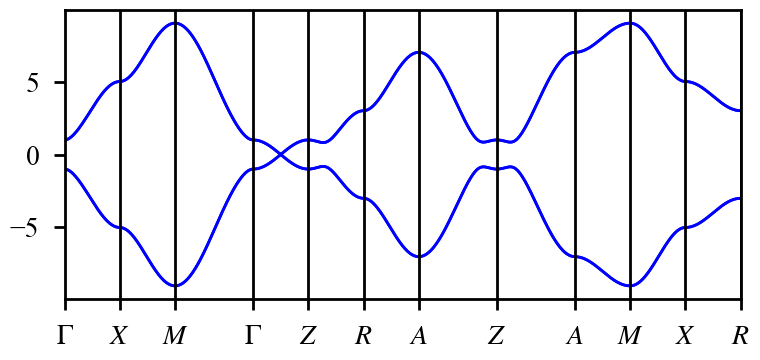

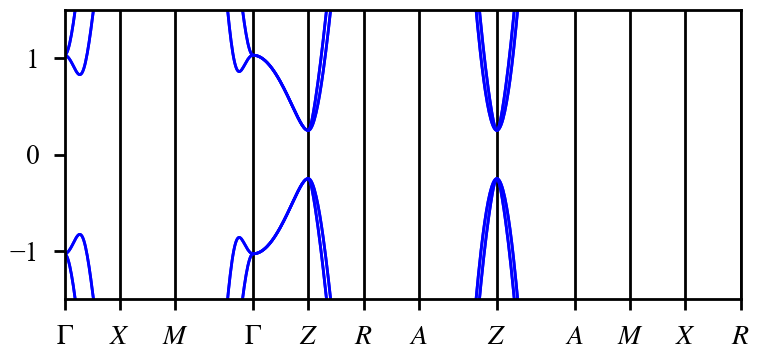

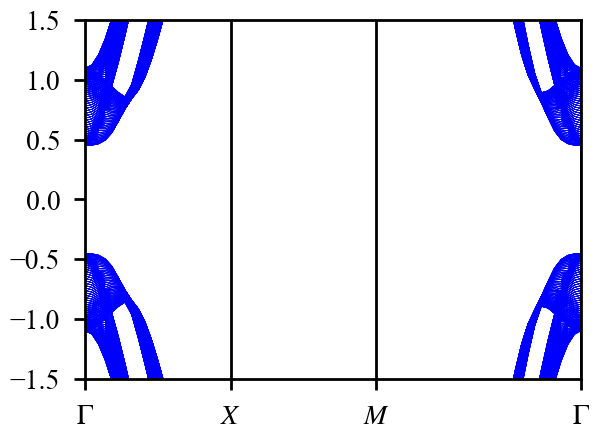

In [99]:
# No CDW
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(no_cdw_evals, 'b-', linewidth=2)

ax.set_xticks(k_nodes_3d)
ax.set_xticklabels(labels_3d)
ax.set_xmargin(0)

for k in k_nodes_3d[1:]:
    ax.axvline(k, color='k')

plt.tight_layout()
plt.show()

# Momentum space CDW
fig, ax = plt.subplots(figsize=(8, 4))

for k in k_nodes_3d[1:]:
    ax.axvline(k, color='k')
    
ax.plot(cdw_evals, 'b-', linewidth=2)

ax.set_xticks(k_nodes_3d)
ax.set_xticklabels(labels_3d)
ax.set_xmargin(0)

ax.set_ylim(-1.5, 1.5)


plt.tight_layout()
plt.show()

# Coordinate space CDW
fig, ax = plt.subplots()

for k in k_nodes_2d[1:]:
    ax.axvline(k, color='k')

ax.plot(coord_evals, 'b-', linewidth=0.5)

ax.set_xticks(k_nodes_2d)
ax.set_xticklabels(labels_2d)
ax.set_xmargin(0)

# for y in (coord_band_edge, -coord_band_edge):
#     ax.axhline(y, linestyle='dashed', color='k')

ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()